In [2]:
using FFTW

In [3]:
using Plots
using Dates
using BenchmarkTools

# The Kuramoto-Sivashinsky Equation: Numerics

The Kuramoto-Sivashinsky equation is a PDE that was originally formulated to describe the [fronts of laminar flames](https://www.jstor.org/stable/2100687?seq=1) by G.I. Sivashinsky. The PDE has two forms. In one-dimension, it may be written in *derivative form*:
$$u_t + u u_x + u_{xx} + u_{xxxx} = 0$$
or in *integral form*, which relies on the change of variables $u = v_t$:
$$v_t + \frac 1 2 v_x^2 + v_{xx} + v_{xxxx} = 0$$
In multiple dimensions, it takes the form
$$u_t + a \lvert \nabla u \rvert^2 + \Delta u + \Delta^2 u = 0$$
Where $a$ is often set to $\frac 1 2$

## Julia Harmonic Analysis Tests

In [93]:
function frequency_to_space_2d(c, N, K)
    # c is (2N+1, 2N+1) matrix
    return (x,y) -> begin
        u = 0.0 + 0.0im
        # k goes -N:N, m goes 0:N
        for k in -N:N
            for m in -N:N
                u += c[k+N+1, m+N+1] * exp(im*(k*x + m*y)/K)
                # if m > 0  # Add conjugate for m except m=0
                #     u += conj(c[k+N+1, m+N+1]) * exp(im*(k*x + m*y)/K)
                # end
            end
        end
        return real(u)
    end
end

frequency_to_space_2d (generic function with 1 method)

In [56]:
fftfreq(5)

5-element Frequencies{Float64}:
  0.0
  0.2
  0.4
 -0.4
 -0.2

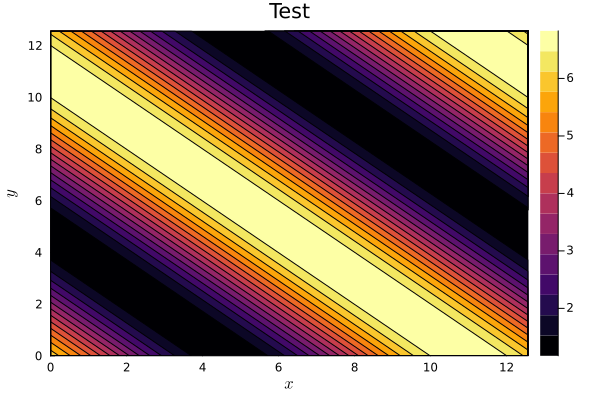

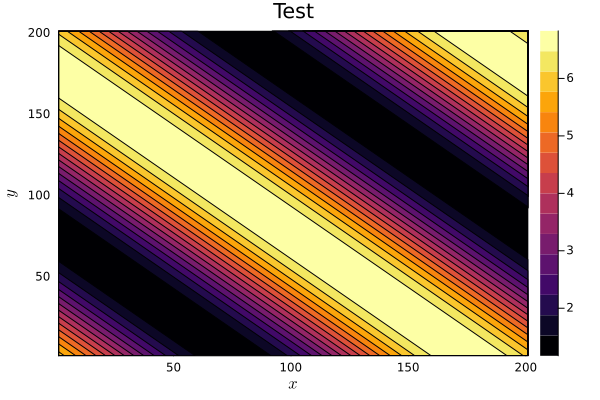

In [113]:
N = 100
K = 2
L = 2 * π * K
mag(x) = sum(abs.(x))
c = zeros(Complex{Float64}, 2N+1, 2N+1)
c[N+1, N+1] = 4
c[N+2, N+2] = 1 + im
c[N, N] = 1 - im
# test = zeros(Complex{Float64}, 2N+1, 2N+1)
# test[3,2] = 3

# indices = [m + k for m in -N:N, k in -N:N]
# display(ifftshift(indices))

u = frequency_to_space_2d(c, N, K)
f = real(fftshift(ifft(ifftshift(c)))').* (2N+1)^2

x = range(0, 2π*K, length=50)
y = range(0, 2π*K, length=50)
display(plot(contourf(x, y, u, title="Test",
    xlabel = "\$x\$",
    ylabel = "\$y\$"
)))
display(plot(contourf(f, title="Test",
    xlabel = "\$x\$",
    ylabel = "\$y\$"
)))
# mag(f - real(f))

# Two-Dimensional Solver
We will use Galerkin reduction, representing $v$ as a partial fourier series
$$v \approx v^N = \sum_{k = -N}^N c_k(t) \exp {\frac{2 \pi i k x}{L}}$$
where the solutions are kept real by enforcing $c_{-k} = c_k^*$. We will also set $L = 2 \pi K$. Then performing Galerkin Reduction, we have the following system of ODEs:
$$\frac{d}{dt}c_m(t) = \left(\frac{m^2}{K^2} - \frac{m^4}{K^4}\right) c_m(t) + \frac{a}{K^2}\sum_{k = -N}^{N} k(m - k) c_k(t)c_{m - k}(t)$$
wherever the summand is defined. We can integrate this using our exponential second-order method.

## Integrator

In [3]:
function Expo_Heun(T, λ, c₀, g, h, N)
    c = zeros(Complex, T, 2N+1, 2N+1)
    # display(λ[N+1-2:N+1+2, N+1-2:N+1+2])
    c[1, :, :] = c₀
    φ(m) = (1 - ℯ^(-m)) / m * (m != 0) + 1 * (m == 0)
    φ₀(m) = 1 / m^2 * (1 - m * ℯ^(-m) - ℯ^(-m)) * (m != 0) + 1/2 * (m == 0)
    φ₁(m) = 1 / m^2 * (m - 1 + ℯ^(-m)) * (m != 0) + 1/2 * (m == 0)
    for i in 1:T-1
        ### Euler Steps
        # if(maximum(abs.(g(c[i, :, :]))) > 100)
        # display(g(c[i, :, :]))
        # end
        c_EULER = ℯ.^(-h * λ) .* c[i, :, :] + h * φ.(h * λ) .* g(c[i, :, :])
        # display(λ)
        # display(φ.(h * λ))

        ### In-class CN Steps
        c[i+1, :, :] = ℯ.^(-h * λ) .* c[i, :, :] + h * φ₀.(h * λ) .* g(c[i, :, :]) + h .* φ₁.(h * λ) .* g(c_EULER)
    end
    return c
end

Expo_Heun (generic function with 1 method)

## Linear/Nonlinear Terms

In [4]:
function compute_lambda(a, b, N, K)
    # Returns diagonal linear terms in (2N+1, N+1) array
    lambda = zeros(Complex{Float64}, 2N+1, 2N+1)
    for k in -N:N
        for m in -N:N
            # L_{k,m} = (k² + m²)/K² - (k² + m²)²/K⁴
            km_squared = (k^2 + m^2)/K^2
            lambda[k+N+1, m+N+1] = - a * km_squared + b * km_squared^2
        end
    end
    return lambda
end

function nonlinear_term(c, s, r, N, K)
    if r == s == 0
        return 0
    end
    res = 0 + 0im
    for m in -N:N
        for k in -N:N
            if (abs(s - m) <= N) & (abs(r - k) <= N)
                res += c[m+N+1,k+N+1] * c[s-m+N+1,r-k+N+1] * (m * (s-m) / K^2 + k * (r-k) / K^2)
            end
        end
    end
    return res
end

function nonlinear_terms(c, a, N, K)
    res = zeros(Complex{Float64}, 2*N+1, 2*N+1)    
    for s in -N:N
        for r in -N:N
            res[s+N+1, r+N+1] = nonlinear_term(c, s, r, N, K)
        end
    end
    return res .* a
end

nonlinear_terms (generic function with 1 method)

### Fourier Series

In [394]:
function nonlinear_terms_fft(c, a, N, K)
    n = 2N + 1
    
    # Step 1: Compute gradients in Fourier space
    ∂x_c = zeros(Complex{Float64}, n, n)
    ∂y_c = zeros(Complex{Float64}, n, n)
    
    for m in -N:N, k in -N:N
        mi, ki = m+N+1, k+N+1
        ∂x_c[mi,ki] = (im*m/K) * c[mi,ki]
        ∂y_c[mi,ki] = (im*k/K) * c[mi,ki]
    end
    
    # Step 2: Transform to physical space 
    u = ifft(ifftshift(c))
    ux = ifft(ifftshift(∂x_c))
    uy = ifft(ifftshift(∂y_c))
    
    # Step 3: Compute |∇u|² in physical space
    grad_sq = abs2.(ux) + abs2.(uy)
    
    # Step 4: Transform back to Fourier space with appropriate scaling
    # The scaling factor should be 1/n² because of the two transforms
    result = fftshift(fft(grad_sq)) / n^2
    
    return result .* a
end

nonlinear_terms_fft (generic function with 2 methods)

In [ ]:
function FFT(m)
    return fftshift(fft(ifftshift(m)))
end
function IFFT(m)
    return fftshift(ifft(ifftshift(m)))
end

function nonlinear_terms_fft(c, N, K)
    # Returns nonlinear term in frequency space
    # 1. Convert to full array and transform to physical
    full = make_full_array(c, N)
    physical = IFFT(full)
    
    # 2. Compute gradients in physical space
    dx_full = zeros(Complex{Float64}, 2N+1, 2N+1)
    dy_full = zeros(Complex{Float64}, 2N+1, 2N+1)
    
    for k in -N:N
        for m in -N:N
            dk = k+N+1
            dm = m+N+1
            dx_full[dk,dm] = im*k/K * full[dk,dm]
            dy_full[dk,dm] = im*m/K * full[dk,dm]
        end
    end
    
    dx = ifft(dx_full)
    dy = ifft(dy_full)
    # println("1: ", (real.(dx).^2 + real.(dy).^2))
    
    # 3. Compute |∇v|² and its average
    grad_squared = real.(dx).^2 + real.(dy).^2
    avg = mean(grad_squared)
    
    # 4. Subtract average and transform back
    nonlinear = -0.5 * (grad_squared .- avg)
    nonlinear_fourier = fft(nonlinear)
    # println(nonlinear_fourier)
    
    # 5. Extract half plane
    return nonlinear_fourier#extract_halfplane(nonlinear_fourier, N)
end

## Frequency Domain $\Longrightarrow$ Spatial Domain

In [5]:
function frequency_to_space_2d(c, N, K)
    # c is (2N+1, 2N+1) matrix
    return (x,y) -> begin
        u = 0.0 + 0.0im
        # k goes -N:N, m goes 0:N
        for k in -N:N
            for m in 0:N
                u += c[k+N+1, m+N+1] * exp(im*(k*x + m*y)/K)
                if m > 0  # Add conjugate for m except m=0
                    u += conj(c[k+N+1, m+N+1]) * exp(im*(k*x - m*y)/K)
                end
            end
        end
        return real(u)
    end
end

frequency_to_space_2d (generic function with 1 method)

## Kuramoto-Sivashinsky Without FFT

In [6]:
N = 12
h = 1/350
K = 5
λ = compute_lambda(1, 1, N, K) .+ .03
g = x -> nonlinear_terms(x, -1/2, N, K)
L = 2 * π * K
x = range(0, 2π*K, length=50)
y = range(0, 2π*K, length=50)

T = 10000

# c₀ = zeros(Complex{Float64}, 2N+1, 2N+1)
# c₀[N+1+2,N+1+2] = 5.0 + 1.0im      # k=1, m=1 
# c₀[N+1+3,N+1+2] = 2.0 + 0.0im
# c₀[N+1+3,N+1+1] = 2.5 + 1.0im      # k=2, m=0
# c₀[N+1-4,N+1+3] = 1.0 + 1.0im      # k=-2, m=2
# c₀[N+1,N+1] = 1.0      # k=-2, m=2
c₀ = [(rand() * 0.01 / (1 + n^2 + m^2)) for n in -N:N, m in -N:N]
c₀[N+1, N+1] = 0
# display(nonlinear_terms(c₀, 1, N, K))

# u = frequency_to_space_2d(c₀, N, K)
# display(contourf(x, y, u, title="Reconstructed"))
c = Expo_Heun(T, λ, c₀, g, h, N);

[ Info: Saved animation to /Users/azul/Documents/Assignments/APMA 2550/Final Exam/kuramoto-sivashinsky/animation.gif


Plots.AnimatedGif("/Users/azul/Documents/Assignments/APMA 2550/Final Exam/kuramoto-sivashinsky/animation.gif")
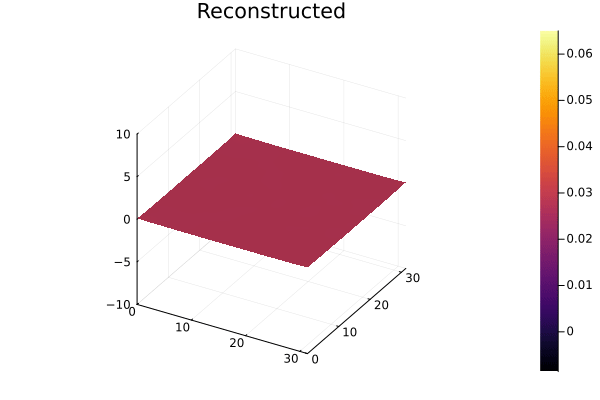

In [7]:
M = 7
anim = @animate for i in 1:100:T
    u = frequency_to_space_2d(c[i,N+1-M:N+1+M, N+1-M:N+1+M], M, K)
    surface(x, y, u, title="Reconstructed", zlims=(-10,10))
end
display(gif(anim, "animation.gif", fps=15))

In [29]:
i = T - 100
u = frequency_to_space_2d(c[i,N+1-M:N+1+M, N+1-M:N+1+M], M, K)
p=surface(x, y, u, title="2 Dimensional KS Equation t = 28", zlims=(-10,10), 
    xlabel = "\$x\$",
    ylabel = "\$y\$",
    size=(1000,700)
)
savefig(p, "plots/ks2d1.png")

"/Users/azul/Documents/Assignments/APMA 2550/Final Exam/kuramoto-sivashinsky/plots/ks2d1.png"

In [31]:
N = (size(c,2)-1)÷2
m = -N:N
# anim = @animate for t in 1:50:size(c,1)
#     heatmap(m, m, log10.(abs2.(c[t,:,:])',).+1e-16, 
#         xlabel="m", ylabel="k", 
#         title="Mode Energies t=$(t)", 
#         clims=(-16,0),  # adjust these limits based on your data
#         colorbar_title="log₁₀(|a_{mk}|²)")
# end
# gif(anim, "animation.gif", fps=15)
p = heatmap(m, m, log10.(abs2.(c[T-100,:,:])',).+1e-16, 
        xlabel="m", ylabel="k", 
        title="Mode Energies t=28", 
        clims=(-16,0),  # adjust these limits based on your data
        colorbar_title="log₁₀(|a_{mk}|²)",
        size=(1000, 700))
savefig(p, "plots/modes.png")

"/Users/azul/Documents/Assignments/APMA 2550/Final Exam/kuramoto-sivashinsky/plots/modes.png"

In [37]:
function energy_in_bands(c, nbands=5)
    N = (size(c,2)-1)÷2
    band_size = N ÷ nbands
    energies = zeros(size(c,1), nbands)
    
    for t in 1:size(c,1)
        for band in 1:nbands
            r_min = (band-1)*band_size
            r_max = band*band_size
            for i in -N:N, j in -N:N
                if r_min ≤ sqrt(i^2 + j^2) < r_max
                    energies[t,band] += abs2(c[t,i+N+1,j+N+1])
                end
            end
        end
    end
    return energies
end
function plot_energy_bands(energies)
    return plot(log10.(energies), label=["1" "2" "3" "4" "5"],
         xlabel="Time", ylabel="log₁₀(Energy)", size=(1000,700), title="Band Energies")
end
p = plot_energy_bands(energy_in_bands(c))
savefig(p, "plots/energy_bands.png")

"/Users/azul/Documents/Assignments/APMA 2550/Final Exam/kuramoto-sivashinsky/plots/energy_bands.png"

## Random Tests

In [390]:
function test_basis_mapping()
    N = 2  # 5×5 matrix
    K = 15.0
    
    # Place a single mode at (1,0) in our basis
    c_test = zeros(Complex{Float64}, 2N+1, 2N+1)
    c_test[N+1+1,N+1] = 1.0  # Mode (1,0)
    
    # Compute gradient directly in our basis
    ∂x = (im/K) * c_test
    ∂y = zeros(size(c_test))
    
    println("Gradient in x:")
    display(∂x)
    
    # Now try FFT approach:
    # Need to map our mode e^(ix/K) to FFT's e^(2πimx/L)
    # Scale factor should be K/(2πL) where L = 2πK
    println("\nEquivalent FFT gradient:")
    c_fft = fft(fftshift(c_test))
    display(c_fft)
end
test_basis_mapping()

Gradient in x:


5×5 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im        0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im        0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im        0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0666667im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im        0.0+0.0im  0.0+0.0im


Equivalent FFT gradient:


5×5 Matrix{ComplexF64}:
 1.0+0.0im  0.309017+0.951057im  -0.809017+0.587785im  …  0.309017-0.951057im
 1.0+0.0im  0.309017+0.951057im  -0.809017+0.587785im     0.309017-0.951057im
 1.0+0.0im  0.309017+0.951057im  -0.809017+0.587785im     0.309017-0.951057im
 1.0+0.0im  0.309017+0.951057im  -0.809017+0.587785im     0.309017-0.951057im
 1.0+0.0im  0.309017+0.951057im  -0.809017+0.587785im     0.309017-0.951057im

In [384]:
N = 2 
display(c)

# Test derivative computation
m_test = -N:N
k_test = -N:N
println("\nSample derivatives for mode (1,1):")
println("dx: ", im/K)
println("dy: ", im/K)

# Print FFT of input
println("\nFFT of input:")
display(fft(c))

5×5 Matrix{Complex{Int64}}:
 1+1im  2+1im  3+1im  4+1im  5+1im
 1+2im  2+2im  3+2im  4+2im  5+2im
 1+3im  2+3im  3+3im  4+3im  5+3im
 1+4im  2+4im  3+4im  4+4im  5+4im
 1+5im  2+5im  3+5im  4+5im  5+5im


Sample derivatives for mode (1,1):
dx: 0.0 + 0.06666666666666667im
dy: 0.0 + 0.06666666666666667im

FFT of input:


5×5 Matrix{ComplexF64}:
     75.0+75.0im  -12.5+17.2048im  …  -12.5-4.0615im  -12.5-17.2048im
 -17.2048-12.5im    0.0+0.0im           0.0+0.0im       0.0+0.0im
  -4.0615-12.5im    0.0+0.0im           0.0+0.0im       0.0+0.0im
   4.0615-12.5im    0.0+0.0im           0.0+0.0im       0.0+0.0im
  17.2048-12.5im    0.0+0.0im           0.0+0.0im       0.0+0.0im

In [395]:
c = [im * k + j for k in 1:5, j in 1:5]
nonlinear_terms(c, 1, 2, K)

5×5 Matrix{ComplexF64}:
       0.0+0.213333im  -0.0177778-0.355556im  …       0.32+0.426667im
 0.0177778-0.355556im         0.0-1.77778im      -0.408889-0.711111im
  0.235556-1.33333im     0.373333-4.0im           -1.09778-2.66667im
  0.231111-0.497778im    0.853333-2.48889im      -0.195556-0.995556im
     -0.32+0.426667im    0.408889-0.711111im           0.0+0.853333im

In [396]:
nonlinear_terms_fft(c, 1, 2, K)

5×5 Matrix{ComplexF64}:
 -0.00540444+1.38778e-19im  …  -0.00540444-0.00213333im
 -0.00202667-0.00106667im      -0.00202667-0.0032im
  0.00401778+0.00106667im       0.00401778-0.00106667im
 -0.00202667+0.0032im          -0.00202667+0.00106667im
 -0.00540444+0.00213333im      -0.00540444-1.38778e-19im

In [220]:
extract_halfplane(c, 2)
make_full_array(extract_halfplane(c, 2), 2)#[3,1]

5×5 Matrix{ComplexF64}:
 1.0+1.0im  2.0+1.0im  3.0+1.0im  3.0-1.0im  2.0-1.0im
 1.0+2.0im  2.0+2.0im  3.0+2.0im  3.0-2.0im  2.0-2.0im
 1.0+3.0im  2.0+3.0im  3.0+3.0im  3.0-3.0im  2.0-3.0im
 1.0+4.0im  2.0+4.0im  3.0+4.0im  3.0-4.0im  2.0-4.0im
 1.0+5.0im  2.0+5.0im  3.0+5.0im  3.0-5.0im  2.0-5.0im

In [ ]:
function compute_nonlinear_term2(c, N, K)
    # Convert to full array and transform to physical
    full = make_full_array(c, N)
    physical = ifft(full)
    
    # Compute gradients in physical space
    dx_full = zeros(Complex{Float64}, 2N+1, 2N+1)
    dy_full = zeros(Complex{Float64}, 2N+1, 2N+1)
    
    for k in -N:N
        for m in -N:N
            dk = k+N+1
            dm = m+N+1
            dx_full[dk,dm] = im*k/K * full[dk,dm]
            dy_full[dk,dm] = im*m/K * full[dk,dm]
        end
    end
    
    dx = ifft(dx_full)
    dy = ifft(dy_full)

    # println("2: ", (real.(dx).^2 + real.(dy).^2))
    
    # Compute |∇v|² and transform back
    nonlinear = -0.5 * (real.(dx).^2 + real.(dy).^2)
    nonlinear_fourier = fft(nonlinear)
    
    # Zero out the (0,0) mode
    nonlinear_fourier[N+1,N+1] = 0
    # println(nonlinear_fourier)
    
    # Extract half plane
    return nonlinear_fourier#extract_halfplane(nonlinear_fourier, N)
end

In [247]:
display(nonlinear_terms(c, 2, 1))

5×5 Matrix{ComplexF64}:
   0.0+48.0im    -4.0-80.0im   …   -52.0-112.0im     72.0+96.0im
   4.0-80.0im     0.0-400.0im     -192.0-560.0im    -92.0-160.0im
  53.0-300.0im   84.0-900.0im     -276.0-1260.0im  -247.0-600.0im
  52.0-112.0im  192.0-560.0im        0.0-784.0im    -44.0-224.0im
 -72.0+96.0im    92.0-160.0im       44.0-224.0im      0.0+192.0im

In [ ]:
function compute_spatial_average_gradient_squared_fourier(c, K, N)
    spatial_average = 0.0
    for k in 0:N
        for m in 0:N
            spatial_average += (k^2 + m^2)/K^2 * abs(c[k+1,m+1])^2
        end
    end
    return spatial_average
end
compute_spatial_average_gradient_squared_fourier(c, K, N)

In [ ]:
function test_fft_transform(c, N)
   # First convert to full array
   full = make_full_array(c, N)
   
   # Transform to physical space
   physical = ifft(full)
   
   # Transform back
   fourier = fft(physical)
   
   # Extract half plane
   c_new = extract_halfplane(fourier, N)
   
   # Compare original and reconstructed coefficients
   max_diff = maximum(abs.(c - c_new))
   println("Maximum difference in coefficients: ", max_diff)
   
   # Visualize both functions
   u_original = frequency_to_space_2d(c, K)
   u_new = frequency_to_space_2d(c_new, K)
   
   x = range(0, 2π*K, length=50)
   y = range(0, 2π*K, length=50)
   z_original = [u_original(xi,yi) for xi in x, yi in y]
   z_new = [u_new(xi,yi) for xi in x, yi in y]
   
   p1 = contourf(x, y, z_original', title="Original")
   p2 = contourf(x, y, z_new', title="Reconstructed")
   plot(p1, p2, layout=(1,2))
end

# Test with our previous example
N = 5
K = 1
c = zeros(Complex{Float64}, 2N+1, N+1)
c[N+2,2] = 5.0 + 1.0im      # k=1, m=1 
c[N+3,2] = 2.0 + 0.0im
c[N+3,1] = 2.5 + 1.0im      # k=2, m=0
c[N-4,3] = 1.0 + 1.0im      # k=-2, m=2

test_fft_transform(c, N)